# TabTransformer

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch    
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time
import random
#ordinal encoder
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
#import lda and pca
from sklearn.decomposition import PCA
import itertools
import copy
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using device:', device)
torch.backends.cuda.enable_mem_efficient_sdp(False)
torch.backends.cuda.enable_flash_sdp(False)
torch.backends.cuda.enable_math_sdp(True)


Using device: cuda


# seed and device definition

In [28]:
SEED = 42
def fix_random(seed: int) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True  # slower
fix_random(SEED)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('Using device:', device)

Using device: cuda


# tabtransformer class definition

In [29]:
class TabTransformer(torch.nn.Module):
    def __init__(self, num_features, num_classes, dim_embedding=8, num_heads=2, num_layers=2):
        super(TabTransformer, self).__init__()
        self.embedding = torch.nn.Linear(num_features, dim_embedding)
        encoder_layer = torch.nn.TransformerEncoderLayer(d_model=dim_embedding, nhead=num_heads, batch_first=True)
        self.transformer = torch.nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = torch.nn.Linear(dim_embedding, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)  # Adding a sequence length dimension
        x = self.transformer(x)
        x = torch.mean(x, dim=1)  # Pooling
        x = self.classifier(x)
        return x

# train and test function

In [30]:
def train_model(model, criterion, optimizer, epochs, data_loader, val_loader, device, scheduler, patience):
    n_iter = 0

    best_model = None
    best_val_loss = float('inf')
    epochs_since_last_improvement = 0

    start = time.time()

    loss_history = []
    val_loss_history = []

    for epoch in range(epochs):
        model.train()

        start_epoch = time.time()

        loss_train = 0
        for data, targets in data_loader:
            data, targets = data.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets.long())
            loss.backward()
            optimizer.step()
            n_iter += 1
            loss_train += loss.item()

        scheduler.step()
        loss_train /= len(data_loader)

        # Compute Val Loss
        val_loss,_,_ = test_model(model, criterion, val_loader)

        loss_history.append(loss_train)
        val_loss_history.append(val_loss)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model)
            epochs_since_last_improvement = 0
        elif epochs_since_last_improvement >= patience:
            break
        else:
            epochs_since_last_improvement += 1

        print('Epoch [{}/{}] - {:.2f} seconds - train_loss: {:.6f} - val_loss: {:.6f} - patience: {}'.format(epoch+1,
              epochs, time.time() - start_epoch, loss_train, val_loss, epochs_since_last_improvement), end='\r')

    print('\nTraining ended after {:.2f} seconds - Best val_loss: {:.6f}'.format(time.time() - start, best_val_loss))

    return best_model, loss_history, val_loss_history


def test_model(model, criterion, loader):
    model.eval()
    y_pred = torch.tensor([],requires_grad=True).to(device)
    y_true = torch.tensor([],requires_grad=True).to(device)

    total_loss = 0.0
    
    for data, targets in loader:
        data, targets = data.to(device), targets.to(device)
        preds = model(data)
        loss = criterion(preds, targets.long())
        total_loss += loss.item()
        y_pred = torch.cat((y_pred, preds.squeeze()))
        y_true = torch.cat((y_true, targets.detach()))

    avg_loss = total_loss / len(loader)
    return avg_loss, y_pred.squeeze(), y_true.squeeze()

# DEFINE TRAIN, VALIDATION AND TEST SET

In [31]:


#read the dataset
df = pd.read_csv('train_dataset.csv')
df.drop(columns=["label"], inplace=True)
#DATA CLEANING

#filter numerical columns
num_columns = df.select_dtypes(include=[np.number]).columns.tolist()

#filter categorical columns
cat_columns = df.select_dtypes(include=[object]).columns.tolist()

# replace '-' values in n columns with the mean of the column(both int and float columns)
for column in num_columns:
    df[column] = df[column].replace('-', df[column].mean())

# replace '-' values in categorical columns with the mode of the column
for column in cat_columns:
    df[column] = df[column].replace('-', df[column].mode().iloc[0])

# Convert all categorical columns to strings
df[cat_columns] = df[cat_columns].astype(str)

encoder = OrdinalEncoder()
df[cat_columns] = encoder.fit_transform(df[cat_columns])

X = df.drop(columns=["type","label"]).to_numpy()
y = df["type"].to_numpy()

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)

# Encoding target
le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)


#PREPROCESSING

# Standardize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Apply LDA
# lda = LinearDiscriminantAnalysis()
# X_train = lda.fit_transform(X_train, y_train)
# X_test = lda.transform(X_test)

#apply PCA
# pca = PCA(n_components='mle',svd_solver='full')
# X_train = pca.fit_transform(X_train)
# X_test = pca.transform(X_test)

# print(f'X_train shape after lda: {X_train.shape}')

num_feature = X_train.shape[1]
num_classes = len(np.unique(y_train))

# Split train data into train and validation
X_train, X_val, Y_train, Y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=SEED)

#tensors creation

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(Y_train, dtype=torch.long)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(Y_val, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

val_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor), batch_size=Y_val.shape[0], shuffle=False)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor), batch_size=y_test.shape[0], shuffle=False)

C:\Users\rinal\AppData\Local\Temp\ipykernel_2780\178297482.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('train_dataset.csv')


In [32]:
#import class weights
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: np.float64(4.069593536153022), 1: np.float64(0.338110666630134), 2: np.float64(1.132579964205406), 3: np.float64(4.543873699714628), 4: np.float64(98.7202), 5: np.float64(2.983745390799734), 6: np.float64(1.196724530863599), 7: np.float64(63.855239327296246), 8: np.float64(0.2880440935324428), 9: np.float64(0.9752262219939147)}


# hp configuration

In [33]:
nums_epochs = [20]
batch_sizes = [512]
patience = [10]
dim_embedding = [32]
num_heads = [8]
num_layers = [16]
learning_rate = [0.001]
hyperparameters = list(itertools.product(nums_epochs, batch_sizes, patience, dim_embedding, num_heads, num_layers, learning_rate))
n_comb = len(hyperparameters)
print (f'Number of hyperparameter combinations: {n_comb}')

Number of hyperparameter combinations: 1


# TRAINING

In [34]:
#Initialize the model, loss, and optimizer
best_loss = float('inf')
criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor(list(class_weights.values()), dtype=torch.float32).to(device))
current_iter = 0
for epochs, batch_size, patience_, dim_embedding_, num_heads_, num_layers_, lr in hyperparameters:
    print(f'Iteration {current_iter+1}/{n_comb} - Hyperparameters: epochs={epochs}, batch_size={batch_size}, patience={patience_}, dim_embedding={dim_embedding_}, num_heads={num_heads_}, num_layers={num_layers_}, lr={lr}')
    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, drop_last=True)

    model = TabTransformer(num_feature, num_classes).to(torch.device('cuda'))
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

    model, loss_history, val_loss_history = train_model(model, criterion, optimizer, epochs, train_loader, val_loader, device, scheduler, patience_)
    val_loss, y_pred, y_true = test_model(model, criterion, val_loader)
    if val_loss < best_loss:
        best_loss = val_loss
        best_model = copy.deepcopy(model)
        best_hyperparameters = f"epochs={epochs}, batch_size={batch_size}, patience={patience_}, dim_embedding={dim_embedding_}, num_heads={num_heads_}, num_layers={num_layers_}, lr={lr}"

    print(f'Hyperparameters: epochs={epochs}, batch_size={batch_size}, patience={patience_}, dim_embedding={dim_embedding_}, num_heads={num_heads_}, num_layers={num_layers_}, lr={lr}')
    print(f'Validation Loss: {val_loss}')

    current_iter += 1

Iteration 1/1 - Hyperparameters: epochs=20, batch_size=512, patience=10, dim_embedding=32, num_heads=8, num_layers=16, lr=0.001
Epoch [20/20] - 7.15 seconds - train_loss: 0.024911 - val_loss: 0.028945 - patience: 0
Training ended after 146.73 seconds - Best val_loss: 0.028945
Hyperparameters: epochs=20, batch_size=512, patience=10, dim_embedding=32, num_heads=8, num_layers=16, lr=0.001
Validation Loss: 0.028944626450538635


 # prediction

Best hyperparameters: epochs=20, batch_size=512, patience=10, dim_embedding=32, num_heads=8, num_layers=16, lr=0.001
Test Loss: 0.01804833486676216
Test Accuracy: 0.9984197859012488
Balanced Accuracy: 0.996505761167873
F1 Score: 0.9984296731734593


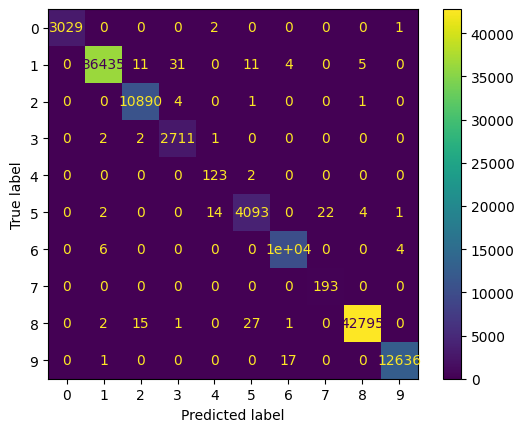

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3032
         1.0       1.00      1.00      1.00     36497
         2.0       1.00      1.00      1.00     10896
         3.0       0.99      1.00      0.99      2716
         4.0       0.88      0.98      0.93       125
         5.0       0.99      0.99      0.99      4136
         6.0       1.00      1.00      1.00     10311
         7.0       0.90      1.00      0.95       193
         8.0       1.00      1.00      1.00     42841
         9.0       1.00      1.00      1.00     12654

    accuracy                           1.00    123401
   macro avg       0.97      1.00      0.99    123401
weighted avg       1.00      1.00      1.00    123401



In [36]:
#import accuracy score,balance accuracy score,f1 score,confusion matrix,classification report
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

test_loss, y_pred, y_true = test_model(best_model, criterion, test_loader)
y_pred = torch.argmax(y_pred, dim=1)
print(f'Best hyperparameters: {best_hyperparameters}')
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {accuracy_score(y_true.cpu().detach().numpy(), y_pred.cpu().detach().numpy())}')
#print balanced accuracy
print(f'Balanced Accuracy: {balanced_accuracy_score(y_true.cpu().detach().numpy(), y_pred.cpu().detach().numpy())}')
#print f1 score
print(f'F1 Score: {f1_score(y_true.cpu().detach().numpy(), y_pred.cpu().detach().numpy(), average="weighted")}')
#compute confusion matrix
cm = confusion_matrix(y_true.cpu().detach().numpy(), y_pred.cpu().detach().numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot()
plt.show()
#print classification report
print(f'Classification Report:\n {classification_report(y_true.cpu().detach().numpy(), y_pred.cpu().detach().numpy())}')
 


# overfitting check

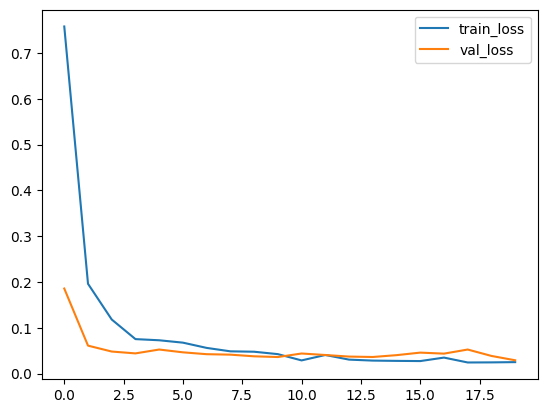

In [37]:
plt.plot(loss_history, label='train_loss')
plt.plot(val_loss_history, label='val_loss')
plt.legend()
plt.show()